# Quantum Hamiltonian Simulation( 'XXX' Heisenberg Spin Model)

### Qiskit Default Solution

In [ ]:
!pip install -U qiskit==0.36.0 --quiet # installing qiskit latest version

In [ ]:
import numpy as np
import pickle
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit import *
from qiskit.tools.monitor import job_monitor
from qiskit.opflow.expectations import PauliExpectation
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.opflow.state_fns import *
from qiskit.quantum_info import *
from qiskit.transpiler.passes import *
from qiskit.opflow import *
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
# load IBMQ Account data
provider = IBMQ.load_account()
# Or
#IBMQ.enable_account('YOUR API-Token')

In [ ]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [ ]:
# Importing State vector simulator
backend = Aer.get_backend('statevector_simulator')
instance = QuantumInstance(backend=backend)

# expectation values
expectation = PauliExpectation()
# Sampler
exm = CircuitSampler(instance)

# Importing FakeJakarta
from qiskit.test.mock import FakeJakarta
fake_jakarta=FakeJakarta()

In [ ]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [ ]:
# Classical simulation example:
#define heidenberg model hamiltonian
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [ ]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

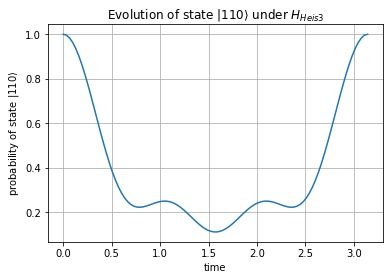

In [ ]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Our Solution.

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

That's how our complete circuit With 6 cnots in the upfold and the same in the downfold, we have a total of 12 cnots in one trotter step.

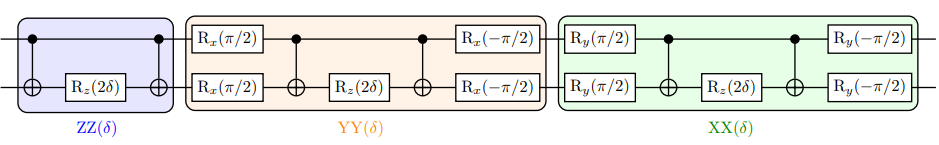

We can directly use pre-built gates for circuit:<br>
RXXGate:   https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html <br>
RYYGate: https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYYGate.html <br>
RZZGate: https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html

In [ ]:
# full circuit for one trot step(12 cnots):
def full_circ(step, time):
    t=time/step
    full_circuit = QuantumCircuit(3)
    for i in range(step):
        full_circuit.rzz(2*t,0,1)
        full_circuit.ryy(2*t,0,1)
        full_circuit.rxx(2*t,0,1)
        full_circuit.rzz(2*t,1,2)
        full_circuit.ryy(2*t,1,2)
        full_circuit.rxx(2*t,1,2)
    return full_circuit

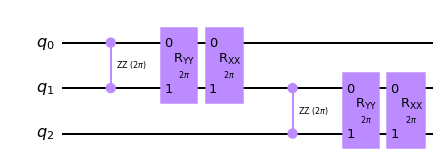

In [ ]:
full_circ(1,np.pi).draw() # draw circuit for 1 trotter steps with 12 cnots

Here's how we can reduce cnot gate using this circuit with 6 cnots in one trotter step.<br>
More about circuit decomposition: https://arxiv.org/abs/1907.03505

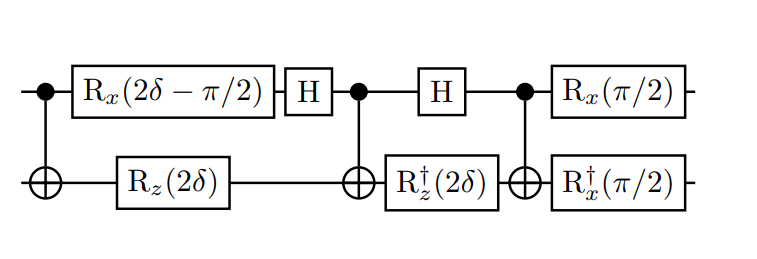

In [ ]:
def simp(t):
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    qc.cnot(0,1)
    qc.rx(2*t-np.pi/2, 0)
    qc.rz(2 * t, 1)
    qc.h(0)
    qc.cnot(0,1)
    qc.h(0)
    qc.rz(-2 * t, 1)
    qc.cnot(0,1)
    qc.rx(np.pi/2,0)
    qc.rx(-np.pi/2,1)
    return qc

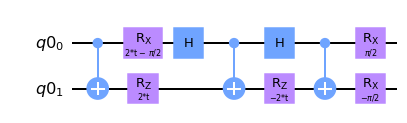

In [ ]:
simp(t).draw() # simplyfied circuit for one trotter steps with half numbers of cnots gate

In [ ]:
# simplified circuit with half numbers of cnots
def sim_circ(trot_steps,t,tar_time):
    dt=tar_time/trot_steps    # time distributed to each trotter steps
    xxx=simp(t).to_instruction()
    Tr=QuantumRegister(3)
    Tc=QuantumCircuit(Tr)
    Tc.append(xxx, [0,1])
    Tc.append(xxx, [1,2])
    Tc=Tc.to_instruction()
    Trot_qr=QuantumRegister(3)
    Trot_qc=QuantumCircuit(Trot_qr, name='xxx')
    for _ in range(trot_steps):
        Trot_qc.append(Tc, [Trot_qr[0],Trot_qr[1],Trot_qr[2]])
    Trot_qc = Trot_qc.bind_parameters({t: dt})
    return Trot_qc

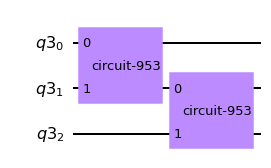

In [ ]:
# full simplified circ(sim_circ) with 6 cnots in one trotter steps.
sim_circ(1,np.pi,np.pi).decompose().draw()

That's not enough, even we can more compress circuit to 9 cnots for any numbers of trotter steps with full state trace as original circuit could perform.<br>
We use Yang Baxter method to fold any n: numbers of trotter steps to three folds only,The parameter will adjust according to that, using para-optimizer, parametric shift for gradient descent and time-steps state Vectors simulator.<br>
More about Yang Baxter Equations: https://arxiv.org/abs/2112.01690

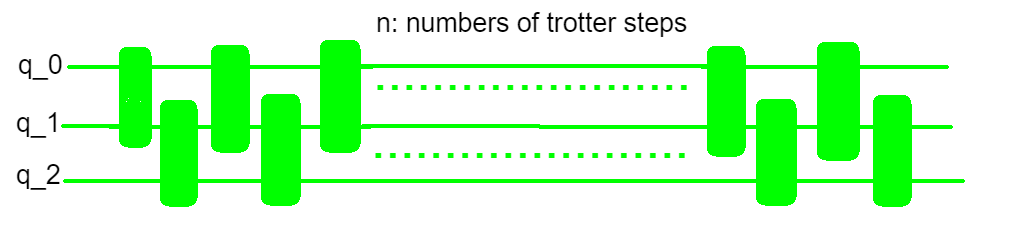

After merging each trotter steps we get our final compressed circuit with 3 folds only, either we apply two fold up and one down or one fold up and two down.

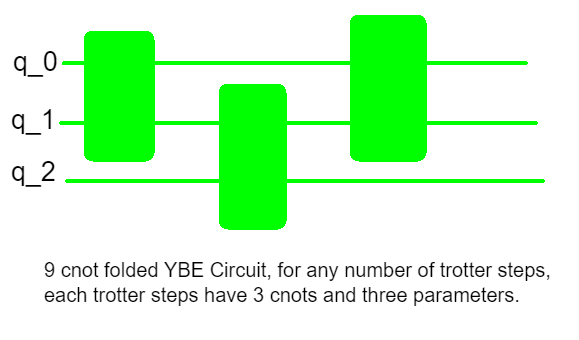

If we revert the order of first two folds[means taking first fold right and second fold left] than we further compress our circuit to 6 cnots only.

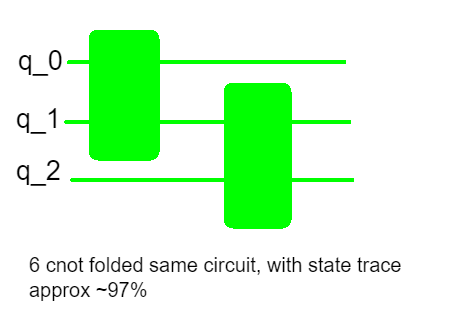

Here we build our circuit for both 9 and 6 cnots gates for any numbers of trotter steps, total 9 parameters required for nine cnot based circuit and 6 for six cnot based circuit.

In [ ]:
# li is the list of 9 parameters after that for 6 parameters.
def folded_circuit_9_cnot(li):
    enums=0 # initial enum is 0
    nine_qc=QuantumCircuit(3)
    def yang_fold(nine_qc,i,j,params):
        nine_qc.cnot(i,j)
        nine_qc.rx(params[0],i)
        nine_qc.rx(-np.pi/2,i)
        nine_qc.h(i)
        nine_qc.rz(params[1],j)
        nine_qc.cnot(i,j)
        nine_qc.h(i)
        nine_qc.rz(params[2],j)
        nine_qc.cnot(i,j)
        nine_qc.rx(np.pi/2,i)
        nine_qc.rx(-np.pi/2,j)
    yang_fold(nine_qc,0,1,li[enums:enums+3]) #total three parameters in one fold.
    enums+=3
    yang_fold(nine_qc,1,2,li[enums:enums+3]) #total three parameters in one fold.
    enums+=3
    yang_fold(nine_qc,0,1,li[enums:enums+3]) #total three parameters in one fold.
    enums+=3
    return nine_qc
#############################################################################################
def folded_circuit_6_cnot(li):
    enums=0 # initial enum is 0
    six_qc=QuantumCircuit(3)
    def yang_fold(six_qc,i,j,params):
        six_qc.cnot(i,j)
        six_qc.rx(params[0],i)
        six_qc.rx(-np.pi/2,i)
        six_qc.h(i)
        six_qc.rz(params[1],j)
        six_qc.cnot(i,j)
        six_qc.h(i)
        six_qc.rz(params[2],j)
        six_qc.cnot(i,j)
        six_qc.rx(np.pi/2,i)
        six_qc.rx(-np.pi/2,j)
    yang_fold(six_qc,0,1,li[enums:enums+3]) #total three parameters in one fold.
    enums+=3
    yang_fold(six_qc,1,2,li[enums:enums+3]) #total three parameters in one fold.
    enums+=3
    return six_qc

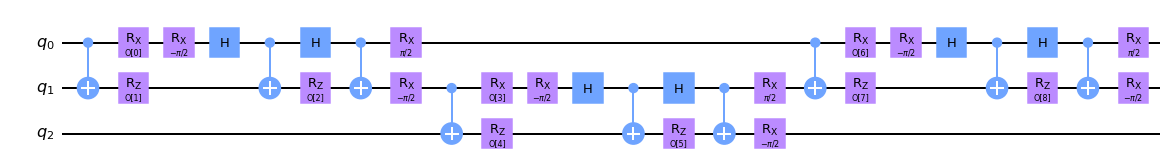

In [ ]:
folded_circuit_9_cnot(ParameterVector('O',9)).draw()

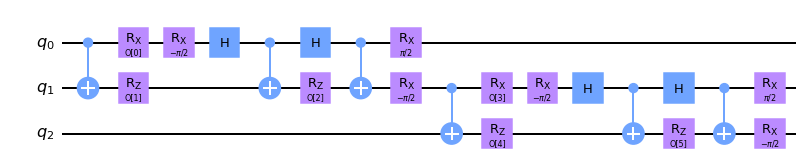

In [ ]:
folded_circuit_6_cnot(ParameterVector('O',6)).draw()

Here para_optimizer functions works as Adam optimizer, feeding parameters  and it  will returns updated parameters for 9 and 6 cnot based circuit.<br>
More about it: https://arxiv.org/abs/1412.6980 <br>
https://www.youtube.com/watch?v=JXQT_vxqwIs

In [ ]:
def para_optimizer(params,enums,alpha,beta,gamma,scale_fac,scale_fac1,cons):
    ty=np.sqrt(1-np.power(scale_fac1,enums))
    ry=(1-np.power(scale_fac,enums))
    length = len(params)
    sigma = [(1-scale_fac1) for i in range(length)]
    if enums==0:
        enums=1
    upto_para=[0 for i in range(length)]
    # define activation function for optimizer
    for i in range(length):
        alpha[i]=scale_fac*alpha[i]+(1-scale_fac)*gamma[i]
        beta[i]=scale_fac1*beta[i]+(1-scale_fac1)*(gamma[i]**2)
        sigma[i]=sigma[i]*ty/ry
        upto_para[i]=params[i]+sigma[i]*(alpha[i]/(np.sqrt(beta[i])+cons))
    return upto_para

In [ ]:
def timer(time_step,mvx):
    if time_step%1 == 0:
        print('starting calibration:', time_step+1)
        print("epoch: ",time_step+1,"-- fitted: " ,mvx)
        print('____________________________________________')

Parametric shift rule gradient descent and how it updates parameters:https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3 <br>
More about parametric shift rule:  https://blueqat.com/gaurav_singh/8fc1aec0-a613-480a-bfcf-afe52d25e486 <br>
https://arxiv.org/pdf/2107.12390

In [ ]:
def vect(i,j):
    vect_zero = np.zeros(j)
    vect_zero[i] = 1
    return vect_zero[:]

def fitting_slope(para,exp,ti,exm):
    list_=[dict(zip(para[:],ti.tolist()))]
    for i in range(len(ti)):
        list_.append(dict(zip(para[:],(ti+vect(i,len(ti))*np.pi/2).tolist())))
        list_.append(dict(zip(para[:],(ti-vect(i,len(ti))*np.pi/2).tolist())))
    value=[]
    for j in list_:
        evl=exm.convert(exp,params =j)
        result=evl.eval().real
        value.append(result)
    total = value[0]
    gamma = np.zeros(len(ti))
    for i in range(len(ti)):
        max_=value[1+2*i]
        min_=value[2+2*i]
        gamma[i]=(max_ - min_)/2
    return total,gamma

Finding expectation values of observables.<br>
https://mitiq.readthedocs.io/en/stable/guide/observables.html

In [ ]:
expec_value = 0.5*(I+Z)
obs = [expec_value for i in range(3)]
total_obs = len(obs)
obser = obs[0]
for x in range(1, total_obs):
    obser = obser^obs[x]
projec =StateFn(obser,is_measurement=True)

In [ ]:
# defining required parameters.
yang_ts = np.linspace(0, np.pi, 100)
t = Parameter("t")
running_steps = 1000
thres = 0.9999
yang_parameter_9_cnot = np.zeros(9)
yang_parameter_6_cnot = np.zeros(6)
total_param_9_cnot = len(yang_parameter_9_cnot)
total_param_6_cnot = len(yang_parameter_6_cnot)
vectors_9_cnot = ParameterVector('O',9)
vectors_6_cnot = ParameterVector('O',6)

In [ ]:
yang_params_9_cnot = []
# Right hand side Circuit
right_circ   = QuantumCircuit(3)
right_circ.x([1,2])
right_circ   = right_circ.compose(folded_circuit_9_cnot(vectors_9_cnot))
# target circuit for assigning new parameters
r_h_s     = right_circ.assign_parameters({vectors_9_cnot: vectors_9_cnot})
updated_para_9_cnot = yang_parameter_9_cnot
alp = np.zeros(total_param_9_cnot)
be = np.zeros(total_param_9_cnot)

In [ ]:
def wave(lhs,rhs):
    num_qc= rhs+lhs.inverse()
    wave_function = expectation.convert(projec@StateFn(num_qc))
    return wave_function

In [ ]:
# this function will combine updated parameters with 9 and 6 cnot circuit.
def yang_fitter(circuit,para_list):
    for para in para_list:
        circ   = QuantumCircuit(3)
        circ.x([1,2])
        circ   = circ.compose(circuit(para))
    return circ

Next two cells will Required 1-1.5 hours to run, total ~3 hours:<br>
_I have already linked Updated parameters list in my zip, please upload it here and directly run after four cells!_

In [ ]:
for (time_step,tar) in enumerate(yang_ts):
  # Left hand side Circuit
    left_circ   = QuantumCircuit(3)
    left_circ.x([1,2])
    left_circ   = left_circ.compose(sim_circ(trot_steps=24,t=t,tar_time=tar)) # sim_circ with time=pi, and total 24 trotter steps, for making equivalence.
    wave_func = wave(left_circ,r_h_s)
    count          = 0
    mx_v_9_cnot = 0.01
    while mx_v_9_cnot < thres and count < running_steps:       
        count = count +1 
        total,gamma = fitting_slope(vectors_9_cnot,wave_func,updated_para_9_cnot,exm)
        slop      = np.asarray(gamma)
        updated_para_9_cnot = np.asarray(para_optimizer(updated_para_9_cnot,count,alp,be,slop,0.9,0.999,1e-8))
        if total > mx_v_9_cnot:
            mx_v_9_cnot       = total
            yang_parameter_9_cnot = updated_para_9_cnot
    yang_params_9_cnot.append(list(yang_parameter_9_cnot))
    timer(time_step,mx_v_9_cnot)
print('_________________________________________________________________')
print("fitting completed")

In [ ]:
yang_params_6_cnot = []
# Right hand side Circuit
right_circ   = QuantumCircuit(3)
right_circ.x([1,2])
right_circ   = right_circ.compose(folded_circuit_6_cnot(vectors_6_cnot))
# target circuit for assigning new parameters
r_h_s     = right_circ.assign_parameters({vectors_6_cnot: vectors_6_cnot})
updated_para_6_cnot = yang_parameter_6_cnot
alp = np.zeros(total_param_6_cnot)
be = np.zeros(total_param_6_cnot)

#### Now we fit updated parameters for 6 cnot two fold circuit.

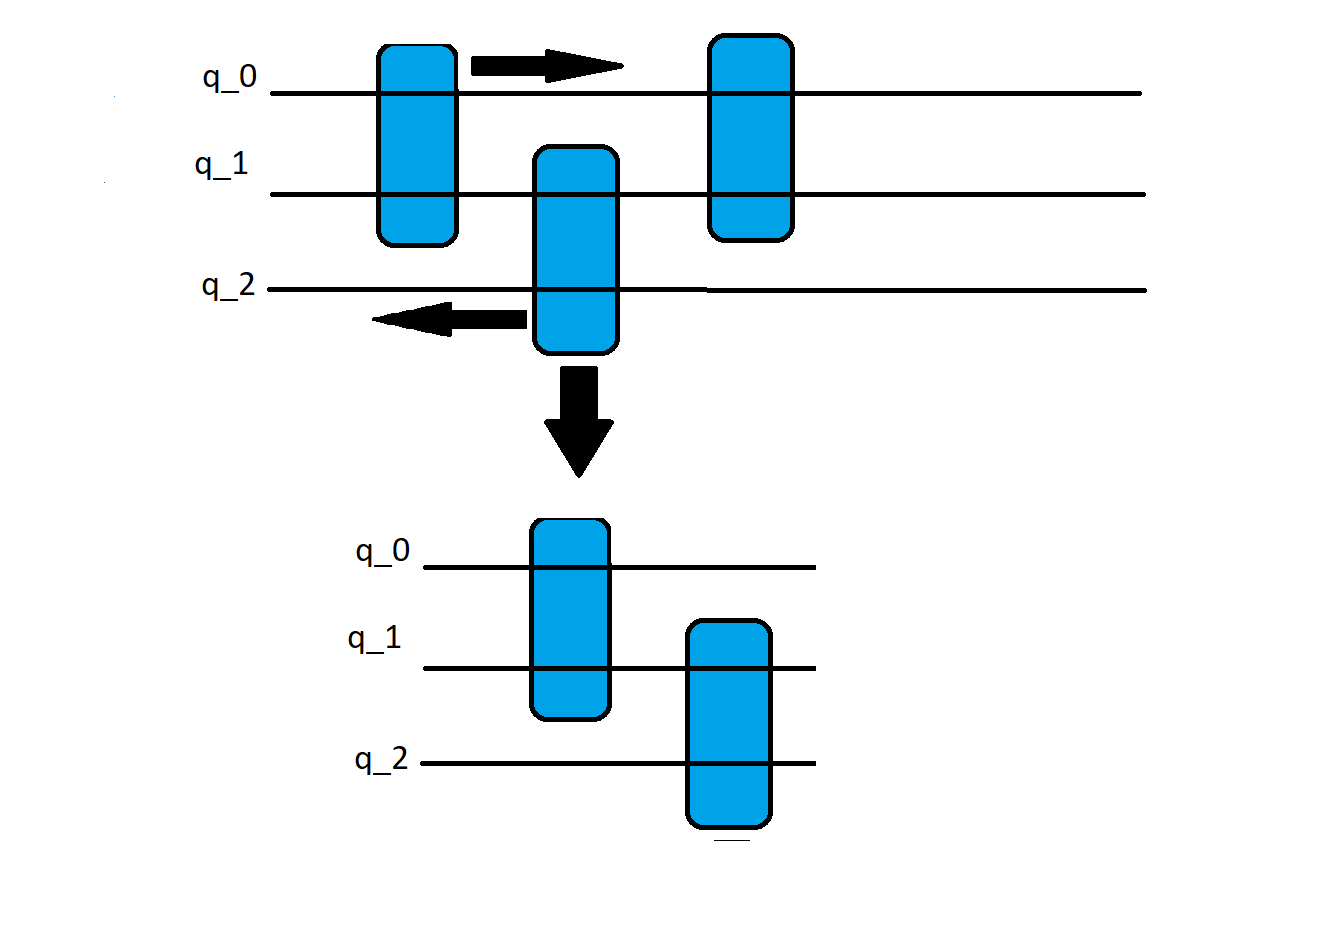

In [ ]:
for (time_step,tar) in enumerate(yang_ts):
  # Left hand side Circuit
    left_circ   = QuantumCircuit(3)
    left_circ.x([1,2])
    left_circ   = left_circ.compose(sim_circ(trot_steps=24,t=t,tar_time=tar)) # sim_circ with time=pi, and total 24 trotter steps, for making equivalence.
    wave_func = wave(left_circ,r_h_s)
    count          = 0
    mx_v_6_cnot = 0.01
    while mx_v_6_cnot < thres and count < running_steps:       
        count = count +1 
        total,gamma = fitting_slope(vectors_6_cnot,wave_func,updated_para_6_cnot,exm)
        slop      = np.asarray(gamma)
        updated_para_6_cnot = np.asarray(para_optimizer(updated_para_6_cnot,count,alp,be,slop,0.9,0.999,1e-8))
        if total > mx_v_6_cnot:
            mx_v_6_cnot       = total
            yang_parameter_6_cnot = updated_para_6_cnot
    yang_params_6_cnot.append(list(yang_parameter_6_cnot))
    timer(time_step,mx_v_6_cnot)
print('_________________________________________________________________')
print("fitting completed")

In [ ]:
# saving data for further use.
pickle.dump(yang_params_9_cnot,open('yang_params_9_cnot','wb'))
pickle.dump(yang_params_6_cnot,open('yang_params_6_cnot','wb'))

please run code from here...

In [ ]:
# calling b-data which we saved in pickle format.
yang_params_9_cnot = pickle.load(open('yang_params_9_cnot','rb'))
yang_params_6_cnot = pickle.load(open('yang_params_6_cnot','rb'))

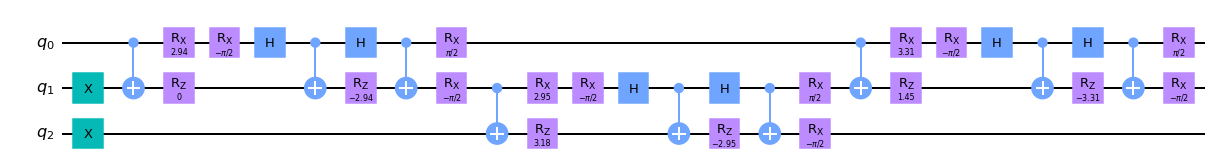

In [ ]:
# Our 9 cnot based circuit, for 24 trotter steps{Note: we can take any number of trotter steps it does'nt matter.}
pri_circuit = yang_fitter(folded_circuit_9_cnot, yang_params_9_cnot)
pri_circuit.draw()

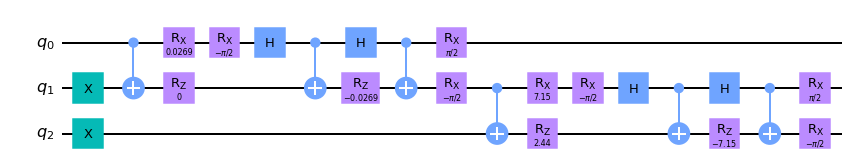

In [ ]:
# 6 Cnot based circuit for 24 trotter steps.
sec_circuit = yang_fitter(folded_circuit_6_cnot, yang_params_6_cnot)
sec_circuit.draw()

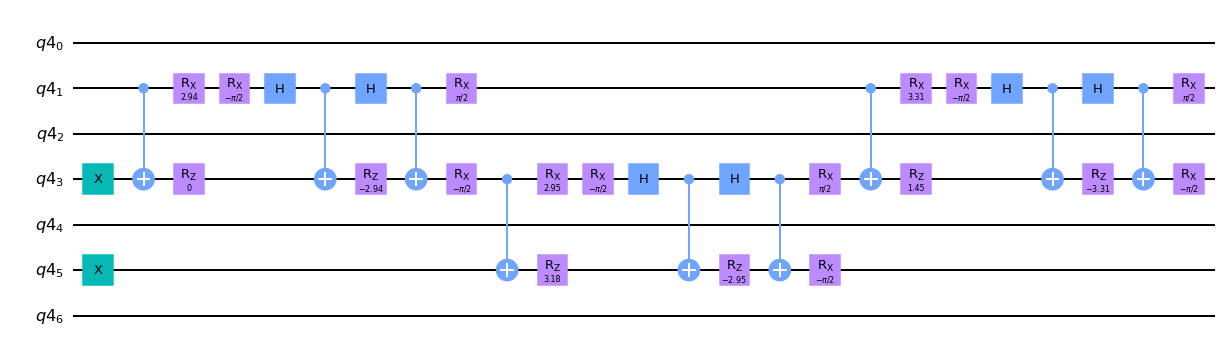

In [ ]:
# for 9-cnot circuit add further insturction for finding state tomography fidelity.
qcr = QuantumRegister(7)
qcs = QuantumCircuit(qcr, name='STF')
qcs.append(pri_circuit, [qcr[1], qcr[3], qcr[5]]) # as instructed by ibm we have to find stf on qubits 1,3,5
st_qcs = state_tomography_circuits(qcs, [qcr[1], qcr[3], qcr[5]])
qcs.decompose().draw()

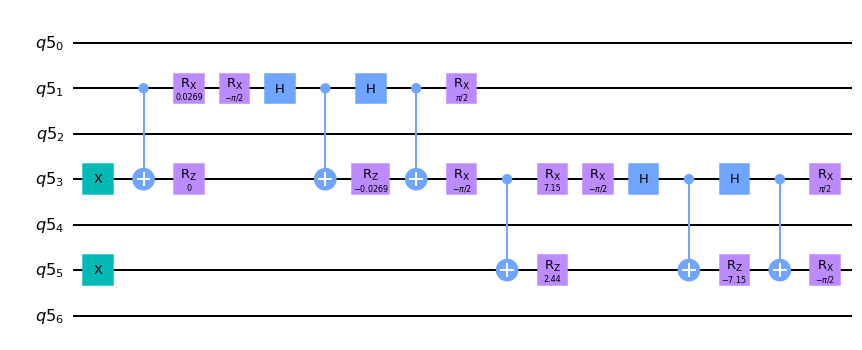

In [ ]:
# similarly for 6 cnot circuit.
qcr1 = QuantumRegister(7)
qcs1 = QuantumCircuit(qcr1, name='STF1')
qcs1.append(sec_circuit, [qcr1[1], qcr1[3], qcr1[5]])
st_qcs1 = state_tomography_circuits(qcs1, [qcr1[1], qcr1[3], qcr1[5]])
qcs1.decompose().draw('mpl')

As circuits are already soo compressed so putting any optimization_level will not affect it.

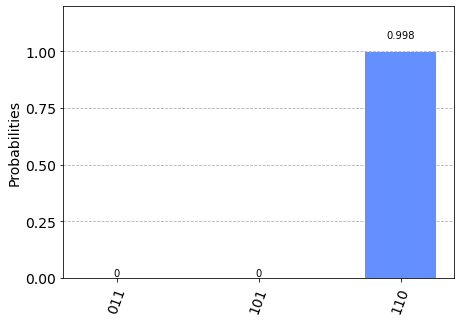

In [ ]:
# running 9 cnot circuit on qasm_simulator
shots = 8192
simulator = Aer.get_backend('qasm_simulator')
backend = simulator
sim_result = execute(st_qcs, backend, shots=shots, optimization_level = 1).result()
plot_histogram(sim_result.get_counts(st_qcs[-1]))

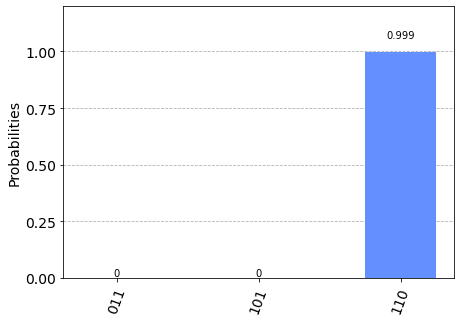

In [ ]:
# running 6 cnot circuit on qasm_simulator
shots = 8192
simulator = Aer.get_backend('qasm_simulator')
backend = simulator
sim_result = execute(st_qcs1, backend, shots=shots, optimization_level = 1).result()
plot_histogram(sim_result.get_counts(st_qcs1[-1]))

In [ ]:
shots = 8192
reps = 8
backend = fake_jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots, optimization_level = 3)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID a27c092a-d647-4775-a83f-99bc6be3d2bb
Job ID a81356db-7d5f-4829-a656-783731e0a730
Job ID d6f665b6-f3a0-4157-81d0-de8cbced66bd
Job ID 684ef658-0f16-43f6-9042-7692f39ed45a
Job ID 3072ea43-81fe-4890-b579-317ff19b1c6c
Job ID bfd711f7-2520-43dc-a068-88590bc353d6
Job ID 8e7780c1-ef71-4ac9-9106-e62318265012
Job ID 13ab4c59-3e99-45fa-be0f-30fe93207c63


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


# Error Mitigation

We are using Measurement error mitigation for QEC:<br>
https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

In [ ]:
# importing library from qiskit.ignis for measurement error mitigation!
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# We have also imported TensoredMeasFitter so we can try it, also for camparing the best result, but here we use only CompleteMeasFitter!

In [ ]:
#getting result from jakarta backend, job which we run earlier:
device_result = job.result()
cal_circuits, state_labels = complete_meas_cal(qubit_list = [1,3,5], qr = st_qcs[-1].qregs[0], circlabel='mitigation')
print(cal_circuits[6])
len(cal_circuits) #  total number of state_labels, 2^3 = 8

            ░          
q4_0: ──────░──────────
            ░ ┌─┐      
q4_1: ──────░─┤M├──────
            ░ └╥┘      
q4_2: ──────░──╫───────
      ┌───┐ ░  ║ ┌─┐   
q4_3: ┤ X ├─░──╫─┤M├───
      └───┘ ░  ║ └╥┘   
q4_4: ──────░──╫──╫────
      ┌───┐ ░  ║  ║ ┌─┐
q4_5: ┤ X ├─░──╫──╫─┤M├
      └───┘ ░  ║  ║ └╥┘
q4_6: ──────░──╫──╫──╫─
            ░  ║  ║  ║ 
c2: 3/═════════╩══╩══╩═
               0  1  2 


8

In [ ]:
shots = 8192
reps = 8
backend = fake_jakarta

jobs = []
for _ in range(reps):
    # execute
    cal_job = execute(cal_circuits, backend, shots=shots, optimization_level = 3)
    print('Job ID', cal_job.job_id())
    jobs.append(cal_job)

Job ID 3c1f1f8a-85ab-4df2-bb23-4eb5baae8248
Job ID cd893142-f349-43ac-95d4-56d3cc12a443
Job ID 3667687a-59b9-4f3d-bbd3-2ee83951db05
Job ID 4ab12db2-793d-4fb5-b454-982baf9ea53b
Job ID 38f11b04-13bf-41d0-9c1b-796b97cd2e73
Job ID b0543519-c1c3-4275-9f0c-66698fbe53f4
Job ID 787f4b06-7f6f-4aa6-ae70-7176d35de741
Job ID 30f07c44-7b11-4caf-9202-5f30b9b9fd4c


In [ ]:
for cal_job in jobs:
    job_monitor(cal_job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


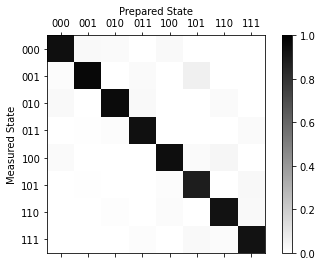

In [ ]:
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration() # plot calibration result of each state!

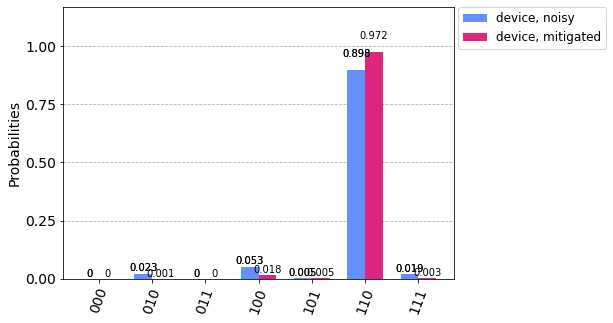

In [ ]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)  # fitting mitigated result on device result!
device_counts = device_result.get_counts(st_qcs[-1])
mitigated_counts = mitigated_result.get_counts(st_qcs[-1])
plot_histogram([device_counts, mitigated_counts], legend = ['device, noisy', 'device, mitigated']) # showing performance before and after QEC!

In [ ]:
# Compute the state tomography based on the st_qcs mitigated quantum circuits and the results from those cal_circuits!
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [ ]:
# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(mitigated_result, st_qcs) # replacing the device result by mitigated result.
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} % \u00B1 {:.4f} %'.format((np.mean(fids)*100), (np.std(fids)*100))) # converting it to percentage!

state tomography fidelity = 98.7148 % ± 0.0000 %


We have Achieved ~98.71 % State tomography fidelity for nine cnot based circuit on simulated backend jakarta with 24 trotter steps. 

In [ ]:
shots = 8192
reps = 8
backend = fake_jakarta

jobs = []
for _ in range(reps):
    # execute
    job1 = execute(st_qcs1, backend, shots=shots, optimization_level = 3)
    print('Job ID', job1.job_id())
    jobs.append(job1)

Job ID 494053fd-027c-44c1-9c8f-201d6d1396cc
Job ID 7fdacfec-2143-45e0-892d-57ec2325cb49
Job ID f34fc3c2-6044-481b-9a69-ea65a6ffd33e
Job ID e3313ebe-3a53-4cc8-a67a-d95a1abaee17
Job ID a929522e-310e-4239-9b7c-3d1ae5bfb725
Job ID 9499aa62-727e-44ad-aeb9-44a93c62d498
Job ID 1c6859a2-d447-4917-9aed-cfc9f12cd1e3
Job ID 42eff193-9cc6-486b-b471-38bed21ecf76


In [ ]:
for job1 in jobs:
    job_monitor(job1)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [ ]:
#getting result from jakarta backend, job which we run earlier:
device_result1 = job1.result()
cal_circuits1, state_labels1 = complete_meas_cal(qubit_list = [1,3,5], qr = st_qcs1[-1].qregs[0], circlabel='mitigation')
print(cal_circuits1[6])
len(cal_circuits1) #  total number of state_labels, 2^3 = 8

            ░          
q5_0: ──────░──────────
            ░ ┌─┐      
q5_1: ──────░─┤M├──────
            ░ └╥┘      
q5_2: ──────░──╫───────
      ┌───┐ ░  ║ ┌─┐   
q5_3: ┤ X ├─░──╫─┤M├───
      └───┘ ░  ║ └╥┘   
q5_4: ──────░──╫──╫────
      ┌───┐ ░  ║  ║ ┌─┐
q5_5: ┤ X ├─░──╫──╫─┤M├
      └───┘ ░  ║  ║ └╥┘
q5_6: ──────░──╫──╫──╫─
            ░  ║  ║  ║ 
c3: 3/═════════╩══╩══╩═
               0  1  2 


8

In [ ]:
shots = 8192
reps = 8
backend = fake_jakarta

jobs = []
for _ in range(reps):
    # execute
    cal_job1 = execute(cal_circuits1, backend, shots=shots, optimization_level = 3)
    print('Job ID', cal_job1.job_id())
    jobs.append(cal_job1)

Job ID 7e8b1d9d-04cb-4df0-85fa-8f86655f23d6
Job ID 29a8e0ae-005a-4f3f-8f9c-26e0fedc482a
Job ID 641c4fe1-b44e-463b-9e17-23393f9af224
Job ID 05912bf0-c405-4111-9b6b-cdb5382d1ac8
Job ID afbd584b-0fbd-4a0e-93ea-83118aff223f
Job ID 78c4d7d9-dbae-46e1-b59b-f38a1d538c4b
Job ID b1e16189-a617-432f-a540-8b17705309a3
Job ID 250a1ab4-8659-4184-814a-e46dc985e424


In [ ]:
for cal_job1 in jobs:
    job_monitor(cal_job1)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


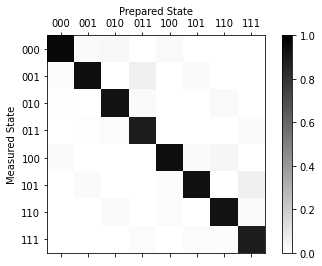

In [ ]:
cal_results1 = cal_job1.result()
meas_fitter1 = CompleteMeasFitter(cal_results1, state_labels1)
meas_fitter1.plot_calibration() # plot calibration result of each state!

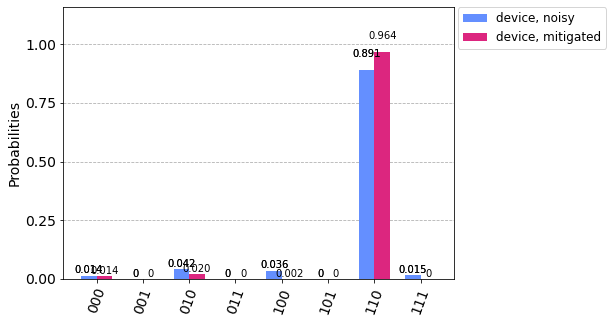

In [ ]:
meas_filter1 = meas_fitter1.filter
mitigated_result1 = meas_filter1.apply(device_result1)  # fitting mitigated result on device result!
device_counts1 = device_result1.get_counts(st_qcs1[-1])
mitigated_counts1 = mitigated_result1.get_counts(st_qcs1[-1])
plot_histogram([device_counts1, mitigated_counts1], legend = ['device, noisy', 'device, mitigated']) # showing performance before and after QEC!

In [ ]:
# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(mitigated_result1, st_qcs1) # replacing the device result by mitigated result.
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} % \u00B1 {:.4f} %'.format((np.mean(fids)*100), (np.std(fids)*100))) # converting it to percentage!

state tomography fidelity = 97.3275 % ± 0.0000 %


So We finally Achieved ~97.32 % State tomography fidelity for six cnot based circuit on simulated backend jakarta with 24 trotter steps

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

# Thank You!